In [1]:
import zipfile, pandas as pd

zip_path = '/content/stock_details_5_years.csv.zip'   # Colab path

with zipfile.ZipFile(zip_path) as z:
    print("Files:", z.namelist()[:10])      # show first few file names

    # preview the first CSV inside
    first_csv = z.namelist()[0]
    with z.open(first_csv) as f:
        df = pd.read_csv(f, nrows=5)
    print(df.head())


Files: ['stock_details_5_years.csv']
                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00             0    AAPL  
1   28123200       0.00             0    MSFT  
2   31004000       0.00             0   GOOGL  
3  132264000       0.00             0    AMZN  
4   54917200       0.04             0    NVDA  



## 1. Unzip & Preview
We start by opening the ZIP file you uploaded, listing its contents, and looking at the first few rows of the raw CSV so we know what columns we have.


In [2]:
import zipfile, pandas as pd

zip_path = '/content/stock_details_5_years.csv.zip'      # your upload
with zipfile.ZipFile(zip_path) as z:
    with z.open('stock_details_5_years.csv') as f:
        raw = pd.read_csv(f, parse_dates=['Date'])

# 1) keep only what we need
price_cols = ['Date','Company','Close']
df = raw[price_cols]

# 2) pivot: rows = dates, columns = tickers, values = close price
prices = df.pivot(index='Date', columns='Company', values='Close')\
           .sort_index()        # tidy ordering
prices.head()



Company,A,AAPL,ABBV,ABEV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,XEL,XOM,XYL,YUM,ZBH,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-29 00:00:00-05:00,69.001251,43.083508,71.184914,3.631820,NaN,67.365654,28.379999,150.171722,249.089996,81.795799,...,147.668747,21.815151,44.753716,61.217907,67.074562,83.960030,107.434830,NaN,37.560001,89.673248
2018-11-30 00:00:00-05:00,69.753235,42.850754,74.636864,3.606481,NaN,68.092094,28.620001,153.388290,250.889999,83.988708,...,148.563202,21.545931,45.552742,61.558617,68.655006,84.289078,109.359970,NaN,39.259998,90.736526
2018-12-03 00:00:00-05:00,71.989975,44.348064,74.153923,3.648712,NaN,68.294380,28.389999,155.532669,255.259995,85.441521,...,150.137817,21.619356,45.978298,62.890438,68.015305,84.151978,108.817947,NaN,39.119999,90.446533
2018-12-04 00:00:00-05:00,70.293159,42.397247,71.691612,3.606481,NaN,65.747253,27.940001,153.099289,245.820007,82.636406,...,146.569305,20.493515,45.882774,61.504402,64.007759,82.881523,104.659248,NaN,37.209999,87.546684
2018-12-06 00:00:00-05:00,69.329056,41.924541,71.517448,3.522021,NaN,65.784035,27.750000,148.474899,250.630005,81.804947,...,145.441925,21.815151,46.212795,60.699108,62.869465,83.631004,105.519012,NaN,42.980000,87.392029


In [3]:
# ── Indicator setup ───────────────────────────────────────────
!pip install -q ta                 # run once; installs technical‑analysis helper
import ta, numpy as np

TICKER = 'AAPL'                    # pick any ticker from prices.columns
close = prices[TICKER].dropna()    # Series of closing prices

# Create a minimal OHLCV frame required by 'ta'
tmp = pd.DataFrame({'Close': close})
tmp['Volume'] = 1                  # dummy volume for completeness

# Add a full set of TA features, then keep a few useful ones
tmp = ta.add_all_ta_features(
        tmp, open='Close', high='Close', low='Close',
        close='Close', volume='Volume',
        fillna=True
)

features = tmp[['Close',
                'trend_sma_fast',      # 10‑day SMA
                'trend_ema_fast',      # 10‑day EMA
                'momentum_rsi',        # RSI
                'volatility_bbh',      # Bollinger Band high
                'volatility_bbl']]     # Bollinger Band low

features.dropna(inplace=True)
print(features.tail())


  Preparing metadata (setup.py) ... done
                                Close  trend_sma_fast  trend_ema_fast  \
Date                                                                    
2023-11-22 00:00:00-05:00  191.309998      187.154179      186.925553   
2023-11-24 00:00:00-05:00  189.970001      187.853280      187.393929   
2023-11-27 00:00:00-05:00  189.789993      188.448332      187.762555   
2023-11-28 00:00:00-05:00  190.399994      189.134165      188.168314   
2023-11-29 00:00:00-05:00  189.884995      189.424582      188.432419   

                           momentum_rsi  volatility_bbh  volatility_bbl  
Date                                                                     
2023-11-22 00:00:00-05:00     71.612657      197.442784      165.319189  
2023-11-24 00:00:00-05:00     67.189198      197.513488      167.578443  
2023-11-27 00:00:00-05:00     66.594111      197.326717      169.944346  
2023-11-28 00:00:00-05:00     67.640064      197.127755      172.176714  
202

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-3-8a94179a9c87>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)


## Compute Technical Indicators Use `ta` to calculate SMA, EMA, RSI, Bollinger Bands, etc., then select the handful we’ll feed into the anomaly models.

In [4]:
from sklearn.ensemble import IsolationForest

# fit an Isolation‑Forest on the indicator features
iso = IsolationForest(
    n_estimators=200,
    contamination=0.01,      # ~1 % of points will be flagged as anomalies
    random_state=42,
    n_jobs=-1
)
iso.fit(features)

# add an anomaly flag column (‑1 = anomaly, 1 = normal)
features['anomaly'] = iso.predict(features)
anomaly_dates = features[features['anomaly'] == -1].index

print(f"Flagged {len(anomaly_dates)} anomalies for {TICKER}.")
features.tail()


Flagged 13 anomalies for AAPL.


<ipython-input-4-fce742d84022>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['anomaly'] = iso.predict(features)


,Close,trend_sma_fast,trend_ema_fast,momentum_rsi,volatility_bbh,volatility_bbl,anomaly
Date,,,,,,,
2023-11-22 00:00:00-05:00,191.309998,187.154179,186.925553,71.612657,197.442784,165.319189,1
2023-11-24 00:00:00-05:00,189.970001,187.853280,187.393929,67.189198,197.513488,167.578443,1
2023-11-27 00:00:00-05:00,189.789993,188.448332,187.762555,66.594111,197.326717,169.944346,1
2023-11-28 00:00:00-05:00,190.399994,189.134165,188.168314,67.640064,197.127755,172.176714,1
2023-11-29 00:00:00-05:00,189.884995,189.424582,188.432419,65.767815,196.462360,174.776077,1


##  Flag Outliers with IsolationForest Fit an Isolation‑Forest on our indicator features to find ~1% of days that “stick out.”

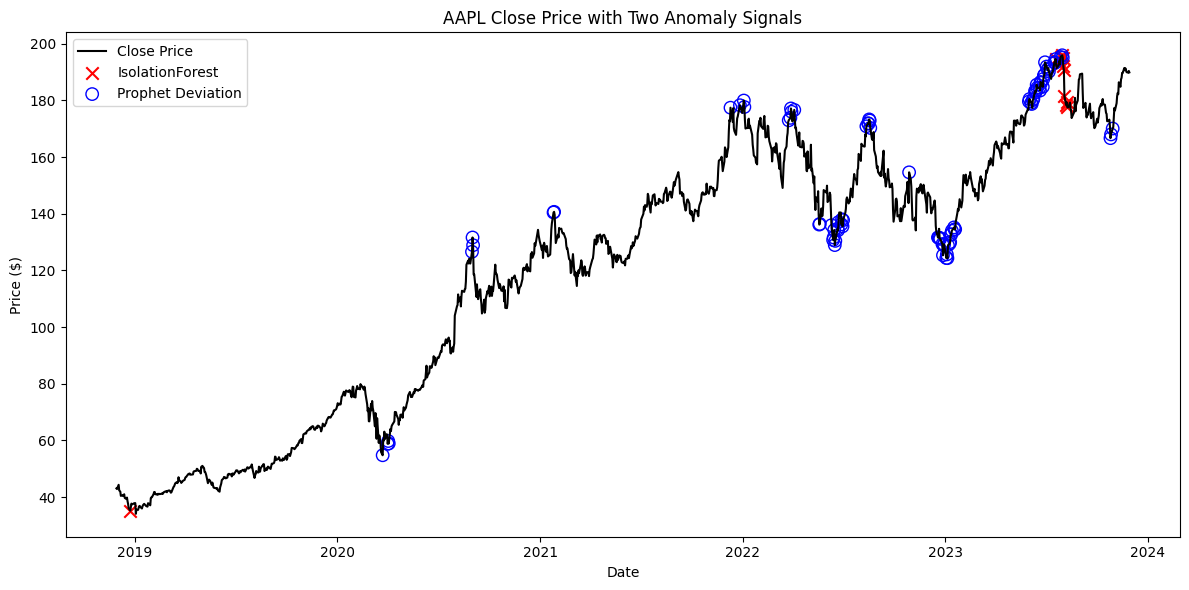

In [15]:


import matplotlib.pyplot as plt
import pandas as pd

# 1. Make sure our price series is tz‑naive
if hasattr(close.index, 'tz') and close.index.tz is not None:
    close.index = close.index.tz_localize(None)

# 2. Turn the raw anomaly date lists into pandas Timestamps and drop any not in our index
def to_naive(ts_list):
    out = []
    for d in ts_list:
        # coerce to Timestamp
        dts = pd.Timestamp(d)
        # strip any tzinfo
        if dts.tzinfo is not None:
            dts = dts.tz_convert(None)
        out.append(dts)
    # keep only those that match our index
    return [d for d in out if d in close.index]

iso_dates     = to_naive(anomaly_dates)  # from IsolationForest
prophet_dates = to_naive(deviate_dates)  # from Prophet

# 3. Plot everything
plt.figure(figsize=(12,6))
plt.plot(close.index, close.values, color='black', label='Close Price')
plt.scatter(iso_dates,     close.loc[iso_dates],     marker='x', color='red',    s=80, label='IsolationForest')
plt.scatter(prophet_dates, close.loc[prophet_dates], facecolors='none', edgecolors='blue', s=80, label='Prophet Deviation')
plt.title(f"{TICKER} Close Price with Two Anomaly Signals")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()


### Forecast & Detect Deviations with Prophet Fit a trend‑only Prophet model and flag days where actual vs. predicted exceeds 3σ